In [2]:
import pathlib

import numpy as np
import astropy.units as u
from astropy.io.fits import CompImageHDU
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import ImageNormalize, LogStretch
import matplotlib.pyplot as plt
import sunpy.map
from sunpy.coordinates import get_earth
import sunpy.io._fits as sunpy_fits
import distributed

from mocksipipeline.detector.response import Channel
from mocksipipeline.physics.spectral import SpectralModel, get_spectral_tables

import synthesizAR
from synthesizAR.instruments import InstrumentDEM

# DEM and Spectral Cubes

Now, use the simulated loops to compute a DEM cube as a function of time at a 1 second cadence

In [2]:
skeleton_low_frequency = synthesizAR.Skeleton.from_asdf('../data/simulations/skeleton_low_frequency.asdf')
skeleton_high_frequency = synthesizAR.Skeleton.from_asdf('../data/simulations/skeleton_high_frequency.asdf')

In [15]:
class InstrumentDEMOXSI(InstrumentDEM):
    name = 'MOXSI_DEM'
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        for c in self.channels:
            c.psf_width = self.psf_width
    
    @property
    @u.quantity_input
    def resolution(self) -> u.Unit('arcsec / pix'):
        return self._moxsi_channel.resolution
    
    @property
    def _moxsi_channel(self):
        # This is just to pull out some useful properties of the instrument for
        # resolution, etc.
        return Channel('filtergram_1')
    
    @property
    def cadence(self) -> u.s:
        return 1 * u.s
    
    @property
    def psf_width(self) -> u.pix:
        psf_fwhm = 40 * u.arcsec
        return psf_fwhm * gaussian_fwhm_to_sigma / self.resolution
    
    @property
    def observatory(self):
        return 'CubIXSS'
    
    @property
    def telescope(self):
        return 'MOXSI'

In [4]:
earth_observer = get_earth(skeleton_high_frequency.loops[0].coordinate.obstime)
#observing_interval = 1.5e4*u.s + [-.5, .5]*u.h
observing_interval = 1.5e4*u.s + [0, 200] * u.s
temperature_bin_edges = 10**np.arange(5.5, 7.6, 0.1)*u.K
pad_fov = [70, 70]*u.arcsec

In [5]:
dem_moxsi = InstrumentDEMOXSI(observing_interval,
                              earth_observer,
                              temperature_bin_edges=temperature_bin_edges,
                              pad_fov=pad_fov)

In [3]:
client = distributed.Client()

In [5]:
client.scheduler.address

'tcp://127.0.0.1:51959'

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51959,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:51975,Total threads: 2
Dashboard: http://127.0.0.1:51978/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:51962,


In [8]:
root_results_dir = pathlib.Path('../data/simulations')

In [9]:
hf_dem_results = root_results_dir / 'high_frequency' / 'dem'
hf_dem_results.mkdir(parents=True, exist_ok=True)

In [10]:
dem_maps = dem_moxsi.observe(skeleton_high_frequency,
                             save_directory=hf_dem_results,
                             channels=dem_moxsi.channels,
                             save_kernels_to_disk=True)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [19]:
dem_maps = sunpy.map.Map(sorted(list((root_results_dir / 'high_frequency' / 'dem').glob('*_t50.fits'))))

In [20]:
norm = ImageNormalize(vmin=1e24, vmax=5e27, stretch=LogStretch())

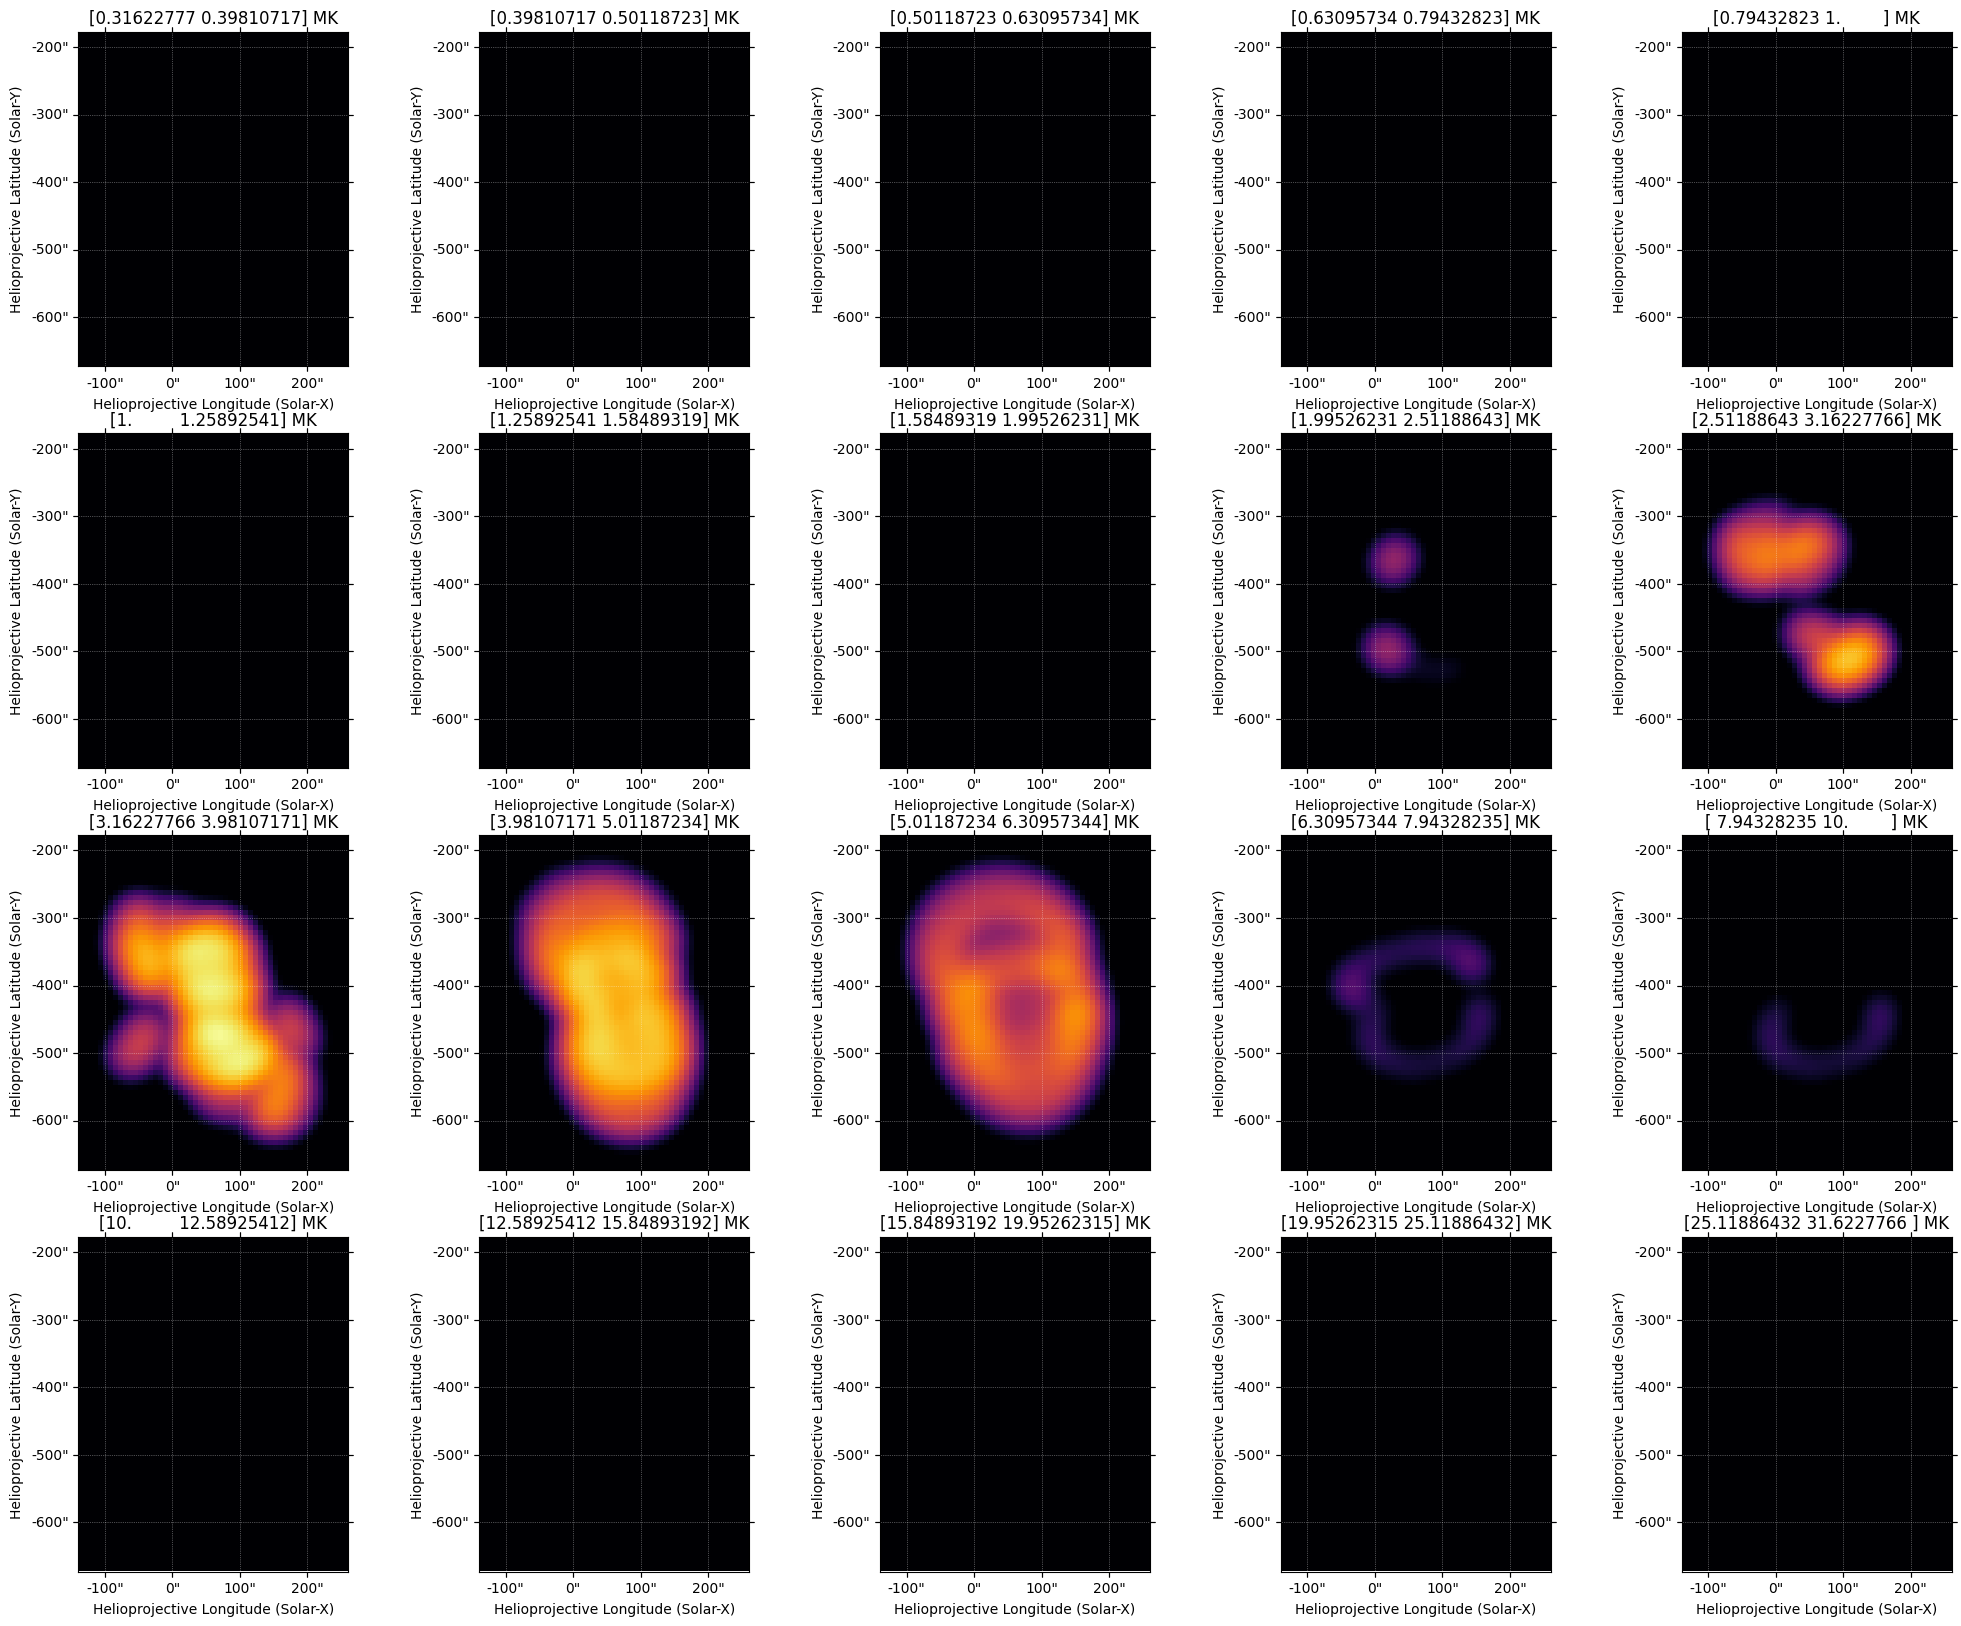

In [21]:
fig = plt.figure(figsize=(25,20))
for i,c in enumerate(dem_maps):
    ax = fig.add_subplot(4,5,i+1,projection=c.wcs)
    c.plot(axes=ax, norm=norm, cmap='inferno')
    ax.set_title(dem_moxsi.temperature_bin_edges[[i,i+1]].to('MK'))

## 4. Compute Spectral Cube

In [40]:
spec_tables = get_spectral_tables()

In [77]:
spec_tables['sun_coronal_1992_feldman_ext_all'].axis_world_coords(1)[0].to('Angstrom')[:2000]

<Quantity [1.00000e-01, 1.55000e-01, 2.10000e-01, ..., 1.09935e+02,
           1.09990e+02, 1.10045e+02] Angstrom>

In [78]:
hf_spec_results = root_results_dir / 'high_frequency' / 'spectral'
hf_spec_results.mkdir(parents=True, exist_ok=True)

In [79]:
spec_table = spec_tables['sun_coronal_1992_feldman_ext_all'][:,:2000]

In [80]:
for i,t in enumerate(dem_moxsi.observing_time):
    dem_maps = sunpy.map.Map(sorted(list(hf_dem_results.glob(f'*_t{i}.fits'))))
    dem_cube = dem_moxsi.dem_maps_list_to_cube(dem_maps, dem_moxsi.temperature_bin_centers)
    header = dem_maps[0].wcs.to_header()
    for k,v in dem_maps[0].meta.items():
        if k.upper() not in header.keys() and k != 'keycomments':
            header[k] = v
    spec_cube = dem_moxsi.calculate_intensity(dem_cube, spec_table, header)
    sunpy_fits.write(hf_spec_results / f'spec_cube_t{i}.fits', spec_cube.data, spec_cube.meta, overwrite=True)

In [56]:
cube_wave = spec_cube.axis_world_coords(0)[0].to('angstrom')

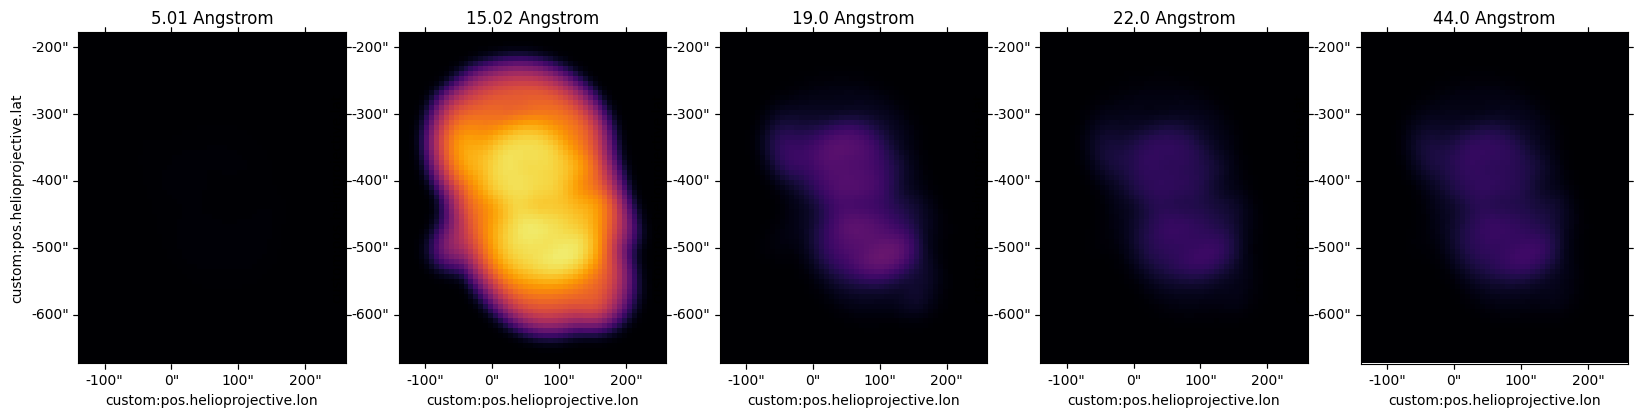

In [57]:
fig = plt.figure(figsize=(20,5))
wave_select = [5.01, 15.02, 19, 22.0, 44] * u.angstrom
norm = ImageNormalize(vmin=0, vmax=5e13, stretch=LogStretch())
for i,ws in enumerate(wave_select):
    i_wave = np.argmin(np.fabs(ws - cube_wave))
    cube_slice = spec_cube[i_wave]
    ax = fig.add_subplot(1,5,i+1,projection=cube_slice.wcs)
    cube_slice.plot(axes=ax,norm=norm,cmap="inferno",data_unit='ph /(angstrom cm2 s sr)')
    ax.set_title(ws)

In [61]:
spec_cube.meta

{'WCSAXES': 3,
 'CRPIX1': 27.5,
 'CRPIX2': 34.0,
 'CDELT1': 0.0020555555555556,
 'CDELT2': 0.0020555555555556,
 'CUNIT1': 'deg',
 'CUNIT2': 'deg',
 'CTYPE1': 'HPLN-TAN',
 'CTYPE2': 'HPLT-TAN',
 'CRVAL1': 0.016826969182899,
 'CRVAL2': -0.11803939384644,
 'LONPOLE': 180.0,
 'LATPOLE': -0.11803939384644,
 'MJDREF': 0.0,
 'DATE-OBS': '2020-11-09T17:59:57.340',
 'MJD-OBS': 59162.749969213,
 'RSUN_REF': 696000000.0,
 'DSUN_OBS': 148154617444.64,
 'HGLN_OBS': 0.0,
 'HGLT_OBS': 3.4233542990553,
 'SIMPLE': True,
 'BITPIX': -64,
 'NAXIS': 3,
 'NAXIS1': 54,
 'NAXIS2': 67,
 'INSTRUME': 'MOXSI',
 'TELESCOP': 'MOXSI',
 'OBSRVTRY': 'CubIXSS',
 'DETECTOR': 'MOXSI',
 'PC1_1': 1.0,
 'PC1_2': -0.0,
 'PC2_1': 0.0,
 'PC2_2': 1.0,
 'RSUN_OBS': 968.9933103314404,
 'BUNIT': 'ph / (Angstrom cm2 s sr)',
 'DATE_SIM': '2020-11-09T22:10:47.340',
 'CDELT3': 0.05499999999999999,
 'CTYPE3': 'WAVE',
 'CUNIT3': 'Angstrom',
 'CRPIX3': 1,
 'CRVAL3': 0.1,
 'NAXIS3': 9090,
 'COMMENT': ,
 'HISTORY': }

In [82]:
from mocksipipeline.util import read_data_cube

In [83]:
foo = read_data_cube(hf_spec_results / 'spec_cube_t99.fits')

In [84]:
foo

NDCube
------
Dimensions: [2000.   67.   54.] pix
Physical Types of Axes: [('em.wl',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: ph / (Angstrom cm2 s sr)
Data Type: >f8

In [56]:
cube_wave = foo.axis_world_coords(0)[0].to('angstrom')

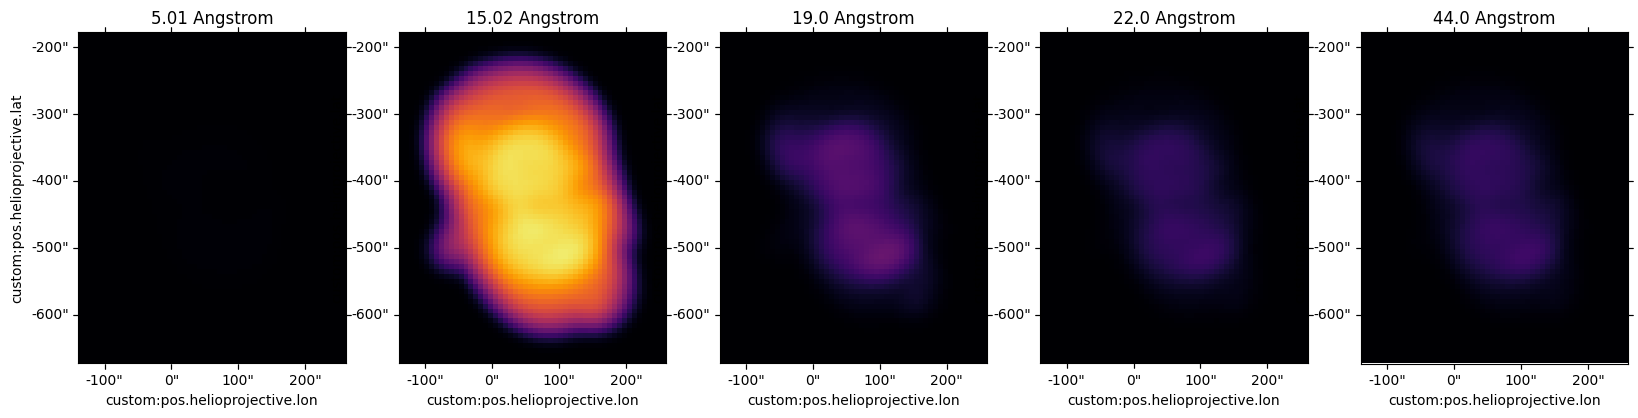

2023-06-15 14:35:49,625 - distributed.worker - WARNING - Compute Failed
Key:       instr_cube_to_zarr-93fece23dcb8f5466eb78f14b03d628a
Function:  execute_task
args:      ((<function apply at 0x103a323a0>, <function instr_cube_to_zarr at 0x17aea3670>, (<class 'tuple'>, [0]), {'zarr_store': PosixPath('../data/simulations/high_frequency/instr_cubes.zarr'), 'spec_cube_dir': PosixPath('../data/simulations/high_frequency/spectral'), 'channel': <mocksipipeline.detector.response.SpectrogramChannel object at 0x17840b400>}))
kwargs:    {}
Exception: 'NameError("name \'i\' is not defined")'

2023-06-15 14:35:49,625 - distributed.worker - WARNING - Compute Failed
Key:       instr_cube_to_zarr-cfe7debab21d3a9a38fc1596e03ca4c0
Function:  execute_task
args:      ((<function apply at 0x103a323a0>, <function instr_cube_to_zarr at 0x17c48c160>, (<class 'tuple'>, [5]), {'zarr_store': PosixPath('../data/simulations/high_frequency/instr_cubes.zarr'), 'spec_cube_dir': PosixPath('../data/simulations/high_fre

In [85]:
fig = plt.figure(figsize=(20,5))
wave_select = [5.01, 15.02, 19, 22.0, 44] * u.angstrom
norm = ImageNormalize(vmin=0, vmax=5e13, stretch=LogStretch())
for i,ws in enumerate(wave_select):
    i_wave = np.argmin(np.fabs(ws - cube_wave))
    cube_slice = foo[i_wave]
    ax = fig.add_subplot(1,5,i+1,projection=cube_slice.wcs)
    cube_slice.plot(axes=ax,norm=norm,cmap="inferno",data_unit='ph /(angstrom cm2 s sr)')
    ax.set_title(ws)